GSEAPY Example
--------------------------------------------

### Examples to use ``GSEApy`` inside python console

## 1.  Load essential packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'0.9.8'

**See all supported enrichr library names** 

Enrichr library could be used for ``gsea``, ``ssgsea``, and ``prerank``, too

In [3]:
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down']

## 2. Enrichr Example

### 1)  Assign enrichr with ``pd.Series``,  ``pd.DataFrame``, or ``list`` object

In [4]:
gene_list = pd.read_table("./data/gene_list.txt",header=None)
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [5]:
type(gene_list)

pandas.core.frame.DataFrame

In [6]:
# convert dataframe or series to list
glist = gene_list.squeeze().tolist()
print(glist[:10])

['IGKV4-1', '           CD55', '           IGKC', '        PPFIBP1', '          ABHD4', '          PCSK6', '            PGD', '        ARHGDIB', '          ITGB2', '          CARD6']


#### a. gene_sets support list, str.  
Multi-libraries names supported, separate each name by comma 

In [7]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list="./data/gene_list.txt", 
                 # or gene_list='./gene_list.txt', or gene_list=glist
                 description='test_name', 
                 # or gene_sets='KEGG_2016,KEGG_2013',
                 # or gene_sets=['KEGG_2016','KEGG_2013'],
                 gene_sets='KEGG_2016', 
                 outdir='test/enrichr_kegg', 
                 cutoff=0.5 # test dataset, use lower value of range(0,1)
                )

In [8]:
# access results through res2d attr
# obj.res2d only stores the last enrichr result in your input libraries
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation_Homo sapiens_hsa04380,28/132,3.105774e-13,7.888667e-11,9.026468e-10,2.292723e-07,-1.864151,53.688178,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...
1,KEGG_2016,Tuberculosis_Homo sapiens_hsa05152,31/178,4.290025e-12,5.448332e-10,7.302987e-09,9.274793e-07,-1.779908,46.588613,RAB5B;ITGB2;PPP3R1;HLA-DMA;FCGR3B;HLA-DMB;CASP...
2,KEGG_2016,Phagosome_Homo sapiens_hsa04145,28/154,1.614506e-11,1.366949e-09,1.787601e-08,1.513502e-06,-1.658580,41.214733,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;FCGR3B...
3,KEGG_2016,Leishmaniasis_Homo sapiens_hsa05140,17/73,3.133213e-09,1.591672e-07,6.539155e-07,3.321891e-05,-1.744263,34.154775,TGFB1;IFNGR1;PRKCB;IFNGR2;ITGB2;FOS;MAPK14;HLA...
4,KEGG_2016,Rheumatoid arthritis_Homo sapiens_hsa05323,19/90,2.198322e-09,1.395934e-07,5.292880e-07,3.321891e-05,-1.688825,33.667700,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...


#### b. If multi- libraires are query at one time, the output results are stored into one single dataframe.    
access the Dataframe results by obj.results

In [9]:
enr = gp.enrichr(gene_list="./data/gene_list.txt", 
                 # or gene_list='./gene_list.txt', or gene_list=glist
                 description='test_name', 
                 # or gene_sets='KEGG_2016,KEGG_2013',
                 gene_sets=['KEGG_2016', 'KEGG_2013'],
                 outdir='test/enrichr_kegg2', 
                 cutoff=0.5 # only used for plotting.
                )

In [10]:
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation_Homo sapiens_hsa04380,28/132,3.105774e-13,7.888667e-11,9.026468e-10,2.292723e-07,-1.864151,53.688178,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...
1,KEGG_2016,Tuberculosis_Homo sapiens_hsa05152,31/178,4.290025e-12,5.448332e-10,7.302987e-09,9.274793e-07,-1.779908,46.588613,RAB5B;ITGB2;PPP3R1;HLA-DMA;FCGR3B;HLA-DMB;CASP...
2,KEGG_2016,Phagosome_Homo sapiens_hsa04145,28/154,1.614506e-11,1.366949e-09,1.787601e-08,1.513502e-06,-1.658580,41.214733,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;FCGR3B...
3,KEGG_2016,Leishmaniasis_Homo sapiens_hsa05140,17/73,3.133213e-09,1.591672e-07,6.539155e-07,3.321891e-05,-1.744263,34.154775,TGFB1;IFNGR1;PRKCB;IFNGR2;ITGB2;FOS;MAPK14;HLA...
4,KEGG_2016,Rheumatoid arthritis_Homo sapiens_hsa05323,19/90,2.198322e-09,1.395934e-07,5.292880e-07,3.321891e-05,-1.688825,33.667700,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...


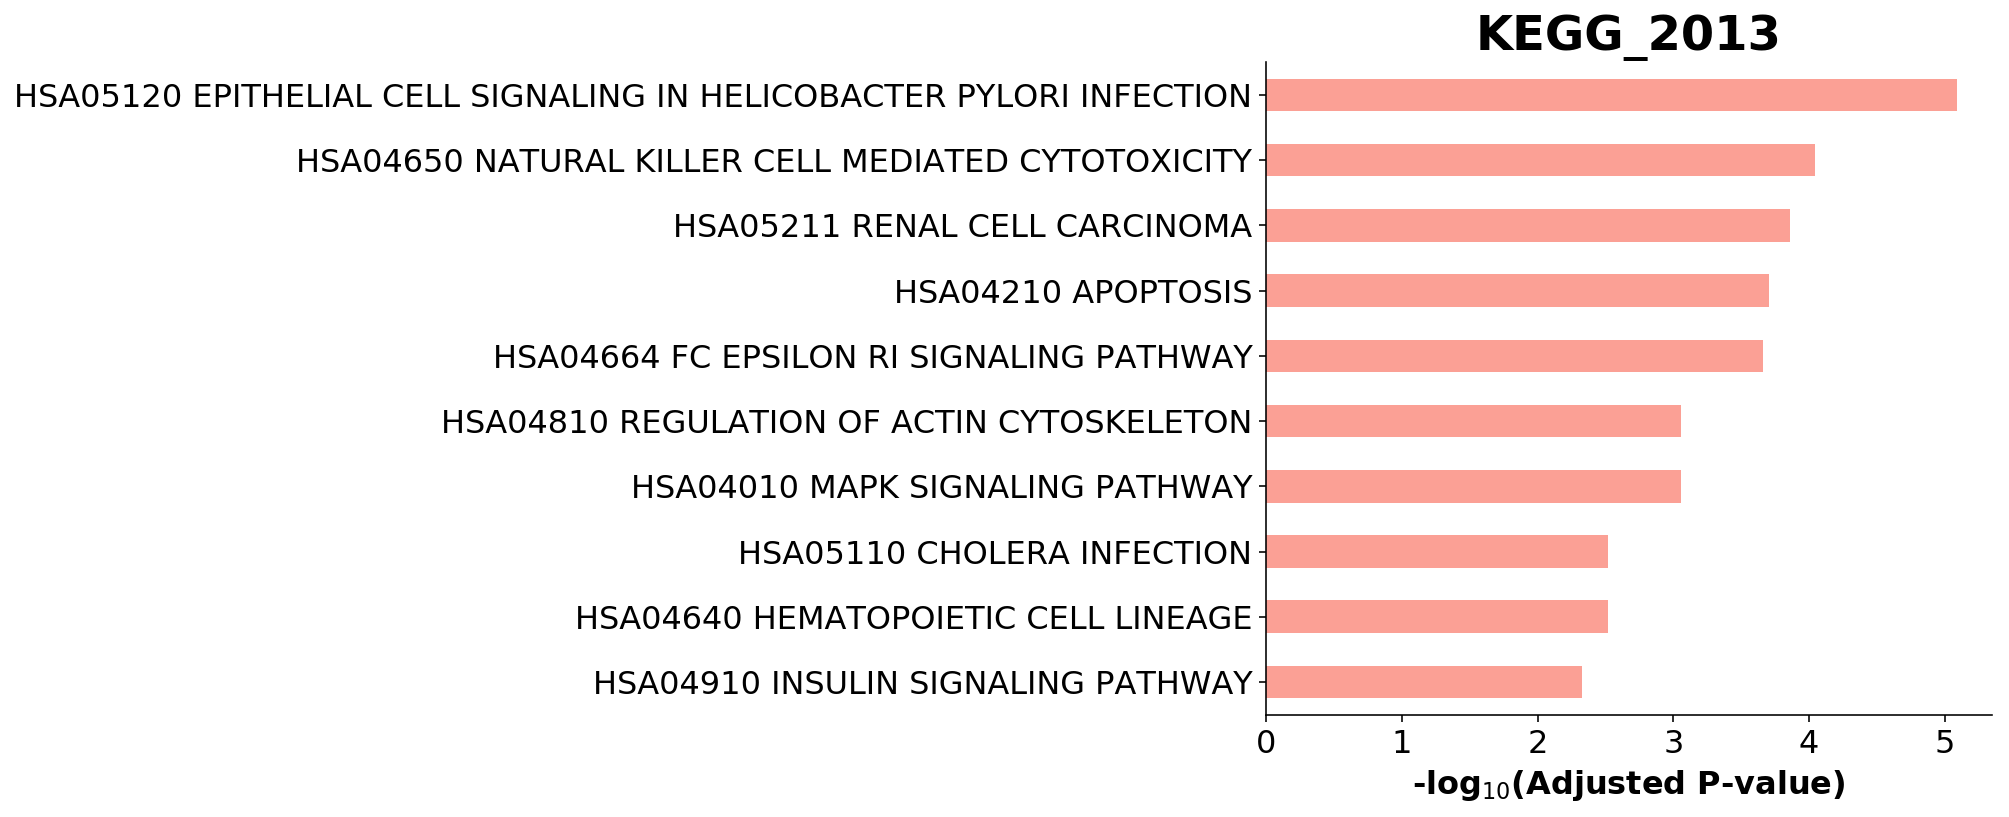

In [11]:
# simple plotting function
from gseapy.plot import barplot, dotplot
barplot(enr.res2d,title='KEGG_2013',)

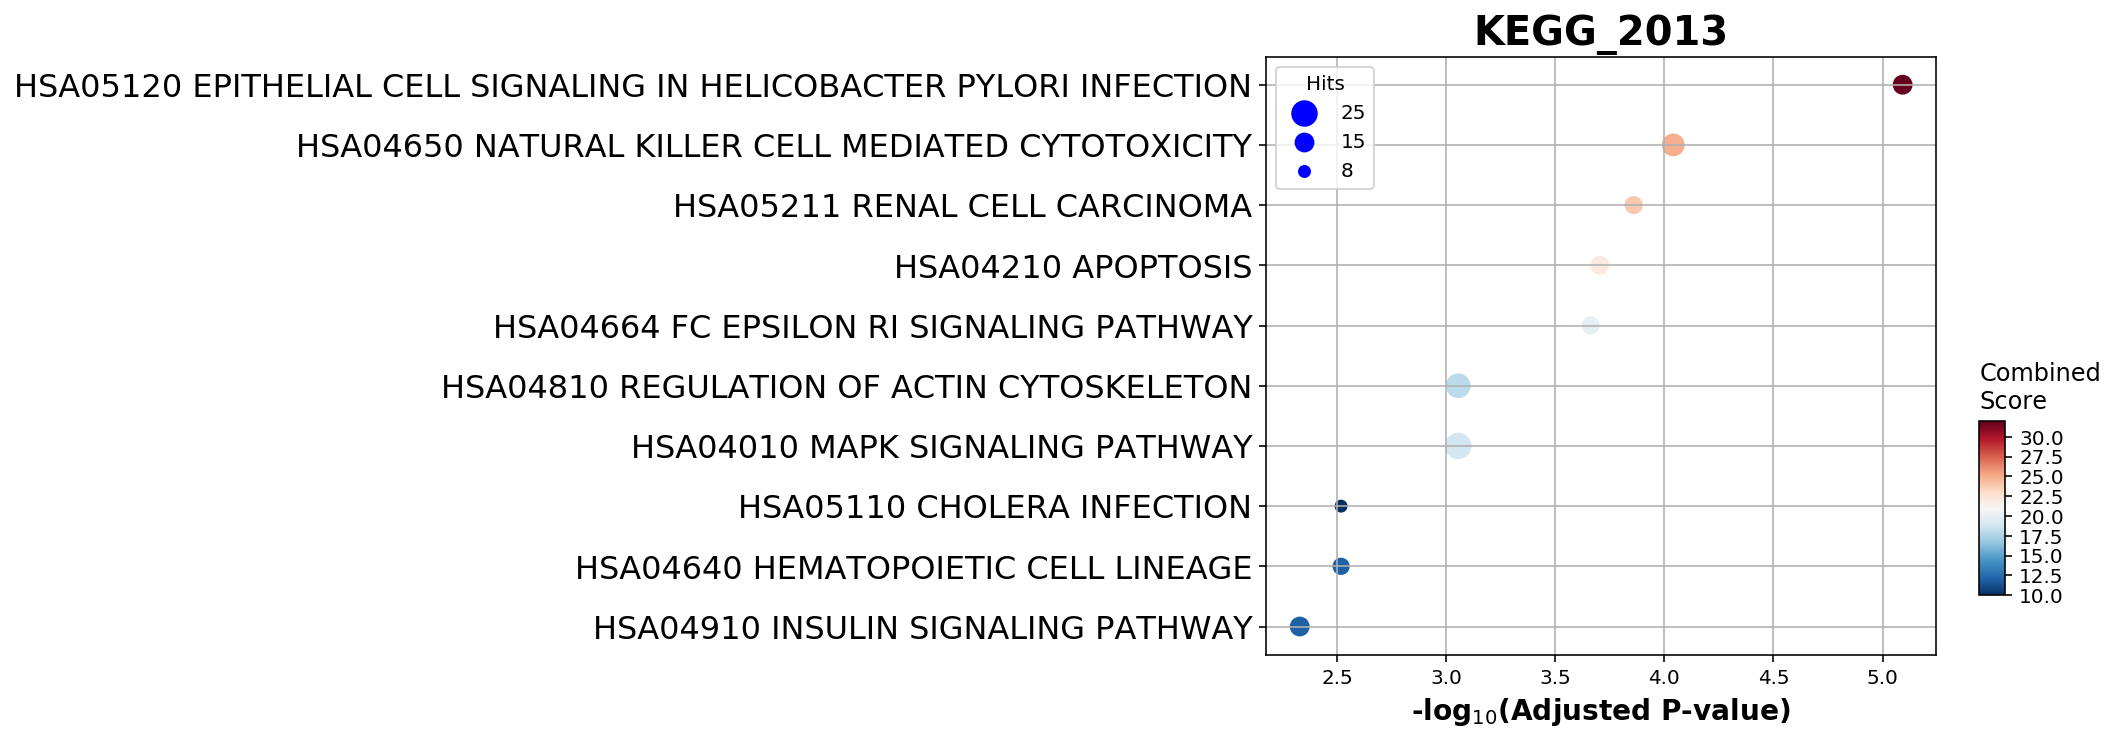

In [12]:
dotplot(enr.res2d, title='KEGG_2013',)

### 2) Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [13]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 --ds BP2017 \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## 3. Prerank example

### 1) Assign prerank()  with a pd.DataFrame, pd.Series , or a txt file
Do not include header in your gene list !  
GSEApy will skip any comment lines startswith "#".  
Only contains two columns, or one cloumn with gene_name indexed when assign a ``DataFrame`` to prerank

In [14]:
rnk = pd.read_table("./data/edb/gsea_data.gsea_data.rnk", header=None)
rnk.head()

,0,1
0,CTLA2B,2.502482
1,SCARA3,2.095578
2,LOC100044683,1.116398
3,CMBL,0.877640
4,CLIC6,0.822181


In [15]:
# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
# use 4 process to acceralate the permutation speed
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2016', 
                     processes=4,
                     permutation_num=100, # reduce number to speed up test
                     outdir='test/prerank_report_kegg',format='png')

Leading edge genes save to the final output results

In [16]:
#access results through res2d attribute or results
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Pathways in cancer_Homo sapiens_hsa05200,-0.188934,-1.042892,0.461538,0.407018,397,27,TGFBR2;LAMB3;RET;PDGFRB;ADCY6;ETS1;TGFA;WNT9A;...,VEGFC;LPAR4;LEF1;RUNX1T1
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,0.418234,1.572603,0.042254,0.442276,265,18,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10;CX...,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10
HTLV-I infection_Homo sapiens_hsa05166,0.338286,1.343902,0.174603,0.708943,258,19,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...
MAPK signaling pathway_Homo sapiens_hsa04010,0.179667,0.692526,0.814286,0.814634,255,18,CACNA1H;TGFBR2;FLNC;MAP3K5;PDGFRB;PPP3CC;NFATC...,CACNA1H;TGFBR2;FLNC;MAP3K5;PDGFRB;PPP3CC
Rap1 signaling pathway_Homo sapiens_hsa04015,0.221306,0.846001,0.683333,0.830352,211,19,CSF1;EFNA1;ARAP3;PDGFRB;ADCY6;PRKD1;MAPK13;FLT...,CSF1;EFNA1


### 2) How to generate your GSEA plot inside python console  
visualize it using ``gseaplot``

In [17]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Pathways in cancer_Homo sapiens_hsa05200',
       'Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060',
       'HTLV-I infection_Homo sapiens_hsa05166',
       'MAPK signaling pathway_Homo sapiens_hsa04010',
       'Rap1 signaling pathway_Homo sapiens_hsa04015',
       'PI3K-Akt signaling pathway_Homo sapiens_hsa04151',
       'Focal adhesion_Homo sapiens_hsa04510',
       'Ras signaling pathway_Homo sapiens_hsa04014',
       'Metabolic pathways_Homo sapiens_hsa01100'],
      dtype='object', name='Term')

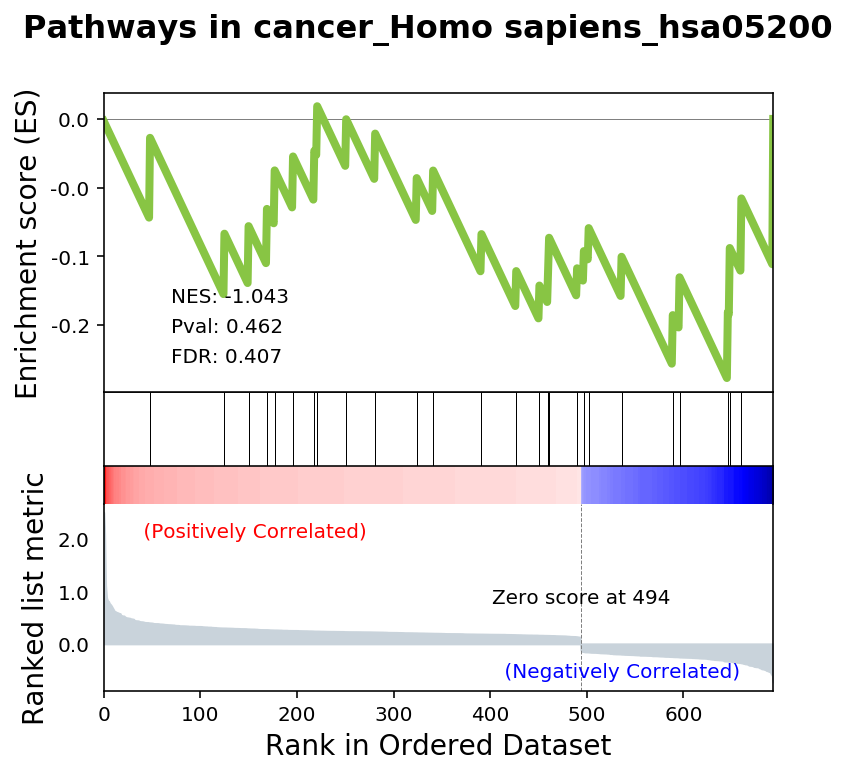

In [18]:
## easy way
from gseapy.plot import gseaplot
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

### 3) Command line usage 

You may also want to use prerank in command line

In [19]:
# ! gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example

### 1)  Assign gsea() with a pandas DataFrame, .gct format file, or a text file

and cls with a list object or just .cls format file 

In [20]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./data/P53.cls")

In [21]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT']


In [22]:
gene_exp = pd.read_table("./data/P53.txt")
gene_exp.head()

,NAME,DESCRIPTION,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,TACC2,na,46.05,82.17,16.87,98.60,141.02,114.32,134.34,44.95,...,68.14,32.21,105.89,64.99,53.52,85.47,18.69,32.16,45.70,48.13
1,C14orf132,na,108.34,59.04,25.61,33.11,42.53,9.12,9.36,310.96,...,159.32,10.71,13.59,53.78,57.57,86.80,17.30,102.66,62.16,73.44
2,AGER,na,42.20,25.75,76.01,40.41,32.17,48.28,58.27,42.40,...,51.50,61.48,44.44,45.68,54.17,62.53,83.18,56.57,50.40,36.75
3,32385_at,na,7.43,13.94,8.55,21.13,15.09,19.05,16.47,7.60,...,30.77,21.27,13.36,16.19,12.07,17.62,22.60,4.50,14.59,11.33
4,RBM17,na,11.40,3.00,3.16,2.34,4.43,1.56,6.04,6.16,...,1.62,2.77,4.42,8.91,12.28,3.04,10.13,8.32,8.23,3.91


In [23]:
print("positively correlated: ", phenoA)

positively correlated:  MUT


In [24]:
print("negtively correlated: ", phenoB)

negtively correlated:  WT


In [25]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # enrichr library names
                 cls= './data/P53.cls', # cls=class_vector
                 #set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 processes=4,
                 format='png')

In [26]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
p53 signaling pathway_Homo sapiens_hsa04115,-0.416999,-1.699280,0.000000,0.280459,69,51,CDKN2A;CHEK1;CCNB1;EI24;CCNG2;SIAH1;SERPINB5;S...,PPM1D;CDK2;BBC3;FAS;DDB2;MDM2;BAX;CDKN1A
Calcium signaling pathway_Homo sapiens_hsa04020,-0.376305,-1.701900,0.000000,0.329365,180,144,ADORA2B;PLCE1;PHKA2;GNA11;PPP3CB;PTGFR;ERBB2;C...,GRIN2C;HTR2A;ITPR2;ADCY2;GRIN2A;TBXA2R;SLC8A1;...
Aldosterone synthesis and secretion_Homo sapiens_hsa04925,-0.438819,-1.707855,0.000000,0.389249,81,66,CREB3L1;CAMK1;CREB3;GNA11;CALM2;CAMK2G;PLCB3;S...,CREB5;MC2R;CACNA1D;ADCY9;PRKD1;ADCY7;PLCB4;PLC...
Jak-STAT signaling pathway_Homo sapiens_hsa04630,-0.338909,-1.408334,0.048077,0.455535,158,125,PIK3CA;EP300;SOCS5;OSMR;IL6ST;IL7R;FHL1;GFAP;I...,STAT5A;GHR;IL10;AKT1;IFNW1;LIF;PIAS1;CTF1;PIAS...
Autoimmune thyroid disease_Homo sapiens_hsa05320,-0.529900,-1.402643,0.058252,0.459913,53,39,HLA-DOB;CGA;CD86;TSHB;IFNA2;TSHR;HLA-DRB4;HLA-...,HLA-DRA;HLA-DMA;IFNA5;HLA-DPA1;IL2;HLA-DQB1;HL...


### 2) Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

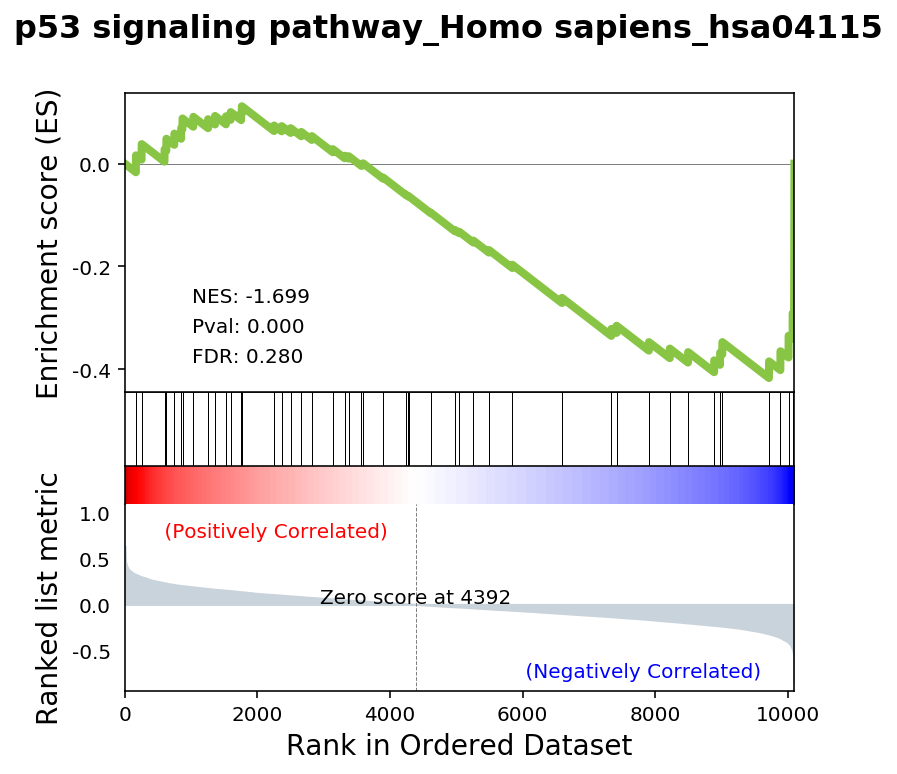

In [27]:
from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.index
gseaplot(gs_res.ranking, term=terms[0], **gs_res.results[terms[0]])

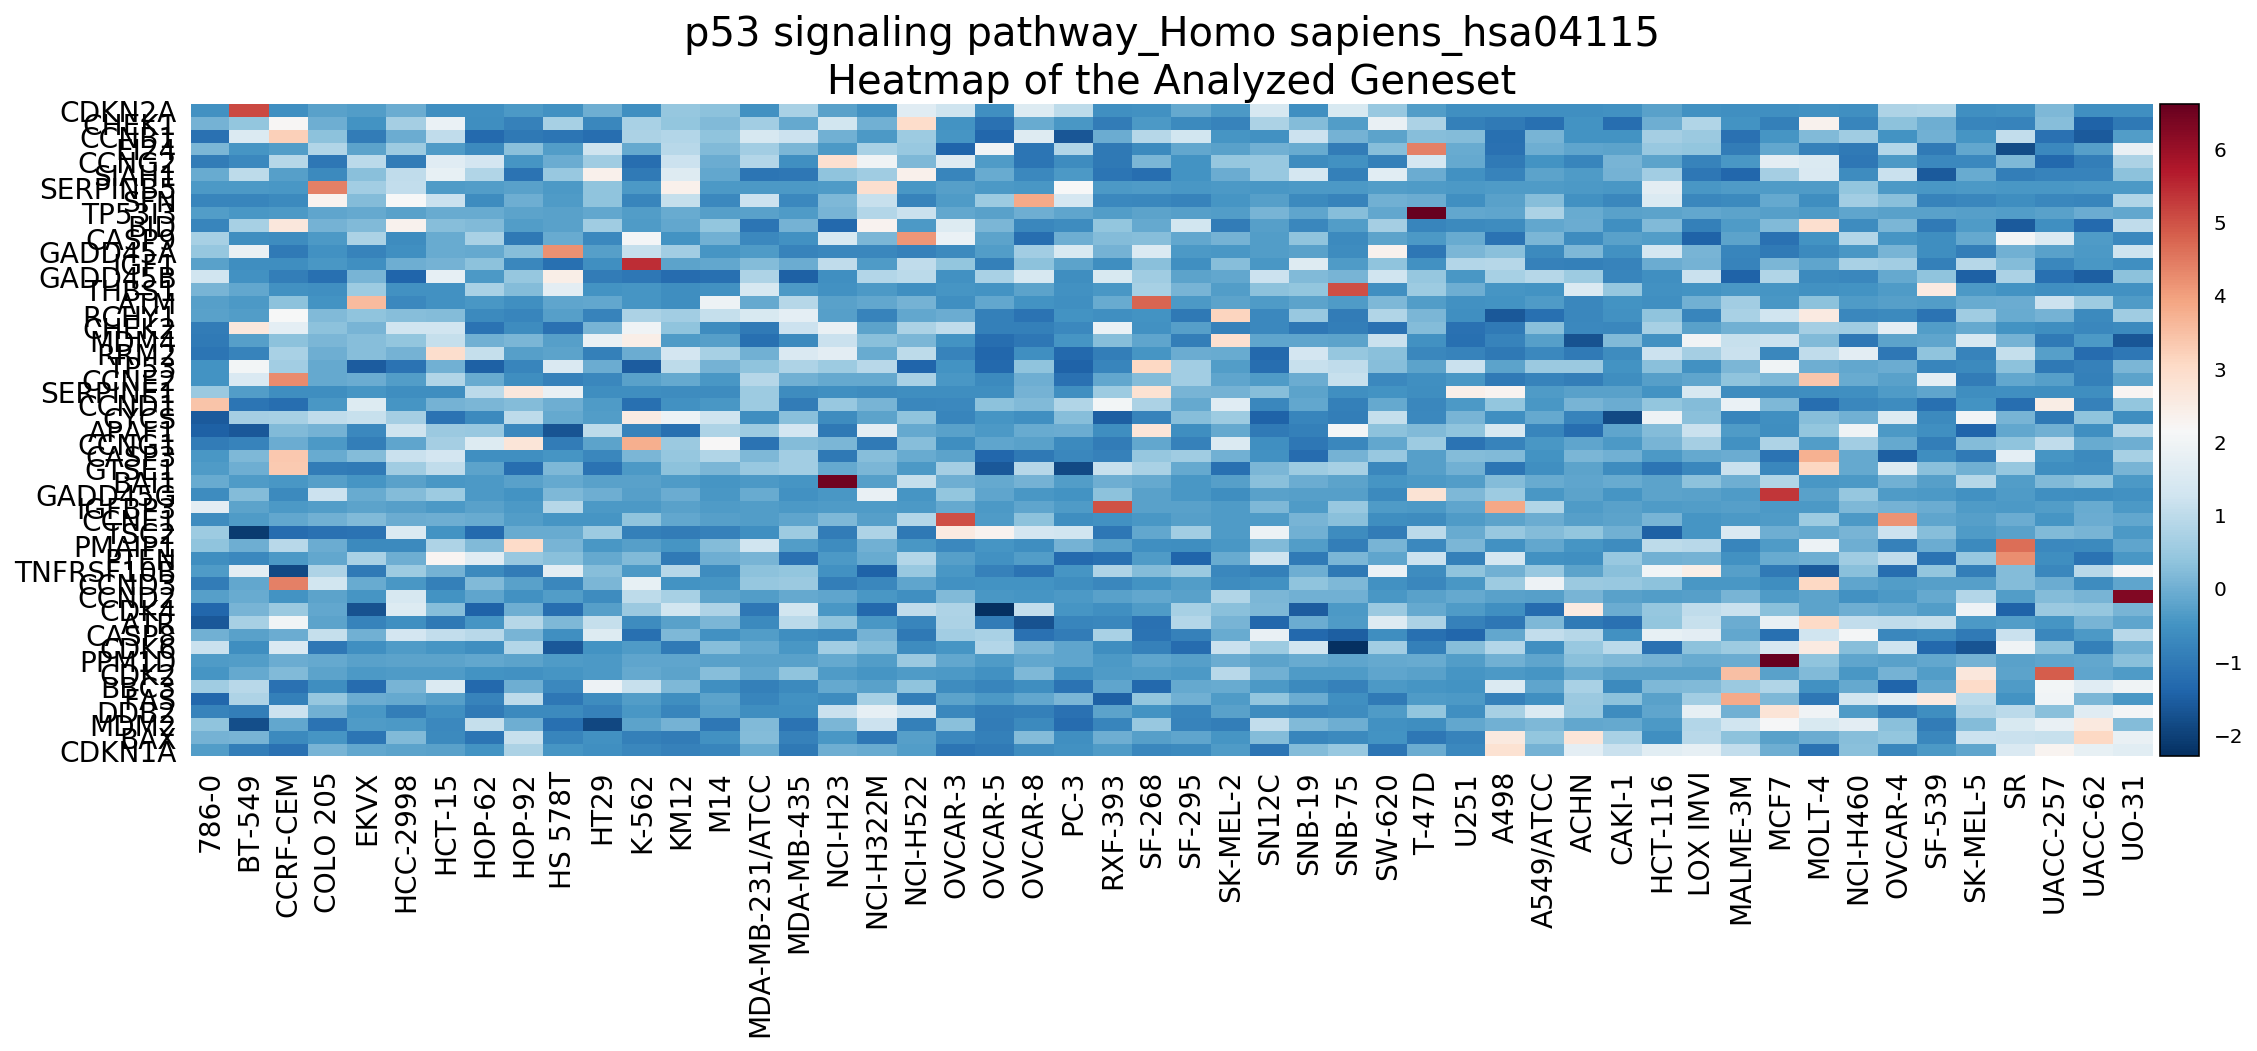

In [28]:
# plotting heatmap
genes = gs_res.res2d.genes[0].split(";")
heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[0], figsize=(18,6))

### 3) Command line usage 

You may also want to use gsea in command line

In [29]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

### 1) Assign ssgsea() with a txt file, gct file, pd.DataFrame, or pd.Seires(gene name as index).  


In [30]:
# txt, gct file input
ss = gp.ssgsea(data="./data/testSet_rand1200.gct",
               gene_sets="./data/randomSets.gmt", 
               outdir='test/ssgsea_report', 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=0, # skip permutation procedure, because you do need it
               no_plot=True, # skip plotting to speed up
               processes=4, format='png')

In [31]:
ss.res2d

,AA488_A1.2,AA489_A2.2,AA490_A3,AA491_B1,AA492_B2,AA493_B3,AA494_C1.2,AA495_C2,AA496_C3,AA497_D1.2,AA498_D3.2,AA499_D2,AA500_x2,AA501_X3,AA502_X2.2,AA503_Y1,AA504_Y2,AA505_Y3
Term|NES,,,,,,,,,,,,,,,,,,
level10_RAND,0.409675,0.412178,0.402321,0.420735,0.423723,0.399593,0.417449,0.426562,0.414945,0.427697,0.428861,0.439795,0.439169,0.429886,0.421071,0.433796,0.436511,0.427593
level12_random,0.623442,0.637662,0.624727,0.636428,0.644896,0.628848,0.645327,0.633330,0.637862,0.647586,0.648293,0.638572,0.652058,0.650088,0.653153,0.660680,0.659886,0.648956
level2_rand,-0.271914,-0.281744,-0.271358,-0.277807,-0.279207,-0.260003,-0.294843,-0.289941,-0.286516,-0.294068,-0.285716,-0.286194,-0.335032,-0.331248,-0.337686,-0.336926,-0.334273,-0.339320
level4_rand,-0.061550,-0.090115,-0.063876,-0.094134,-0.094397,-0.053017,-0.096070,-0.081046,-0.080501,-0.092273,-0.092036,-0.078247,-0.119548,-0.120003,-0.129959,-0.143212,-0.138202,-0.126784
level6_rand,-0.061075,-0.054566,-0.061283,-0.052871,-0.054915,-0.047231,-0.059001,-0.069959,-0.061611,-0.055635,-0.058775,-0.062907,-0.020677,-0.017325,-0.011440,-0.018986,-0.017288,-0.009031
level8_rand,0.145081,0.157404,0.165249,0.160468,0.141703,0.172145,0.139912,0.173172,0.153195,0.146414,0.127259,0.165137,0.175863,0.166732,0.175394,0.166237,0.169276,0.192095
random1,0.154009,0.151312,0.151478,0.147901,0.151960,0.140935,0.154359,0.157054,0.152341,0.150122,0.147418,0.157688,0.125304,0.117738,0.109891,0.113501,0.115591,0.110315
random2,0.114789,0.111621,0.101720,0.112612,0.113221,0.106218,0.120733,0.131228,0.113305,0.125728,0.118026,0.139158,0.090622,0.084933,0.083598,0.080412,0.087921,0.100607
random3,0.090674,0.103528,0.101386,0.099922,0.101013,0.098896,0.095853,0.080370,0.100862,0.089775,0.098816,0.088680,0.098413,0.107809,0.099561,0.103815,0.105186,0.098073


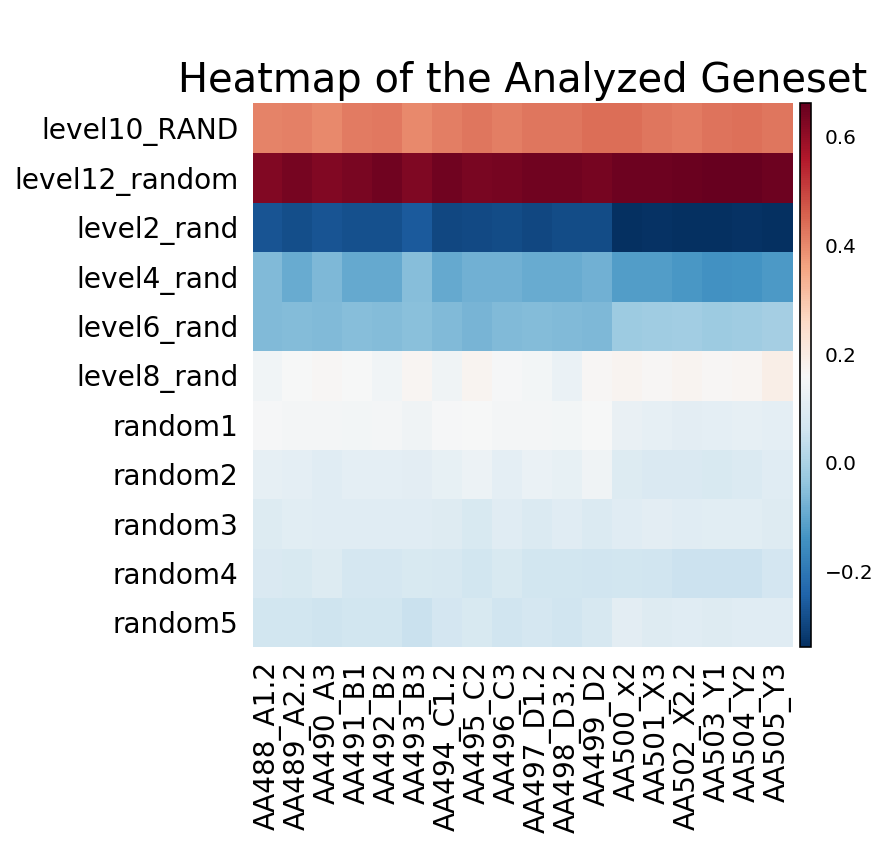

In [32]:
from gseapy.plot import heatmap
heatmap(ss.res2d)

In [33]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_table("./data/temp.txt",header=None)
ssdf.head()

,0,1
0,ATXN1,16.456753
1,UBQLN4,13.989493
2,CALM1,13.745533
3,DLG4,12.796588
4,MRE11A,12.787631


In [34]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.set_index(0)
ssdf2.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [35]:
type(ssdf2)

pandas.core.frame.DataFrame

In [36]:
ssSeries = ssdf2.squeeze()
type(ssSeries)

pandas.core.series.Series

In [37]:
# reuse data
df = pd.read_table("./data/P53_resampling_data.txt")
df.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [38]:
# Series, DataFrame Example
# supports dataframe and series
ssgs = []
for i, dat in enumerate([ssdf, ssdf2, ssSeries, df]):
    sstemp = gp.ssgsea(data=dat, 
                       gene_sets="./data/genes.gmt", 
                       outdir='test/ssgsea_report_'+str(i),
                       scale=False, # set scale to False to get real original ES
                       permutation_num=0, # skip permutation procedure, because you do need it
                       no_plot=True, # skip plotting to speed up
                       processes=4, 
                       format='png')
    ssgs.append(sstemp)

2018-10-20 11:14:28,707 Warning: dropping duplicated gene names, only keep the first values


### 2) Access Enrichment Score (ES) and NES

results save to two attribute:

1. obj.resultsOnSamples: ES
2. obj.res2d: NES

In [39]:
# normalized es save to res2d attri
# one sample input
# NES
ssgs[0].res2d.head()

,1
Term|NES,
BvA_UpIN_A,2.150114
BvA_UpIN_B,2.953848
DvA_UpIN_A,1.985451
DvA_UpIN_D,2.457489
YvX_UpIN_X,2.148816


**Note**: 
If you want to obtain the real original enrichment score,  
you have to set ``scale=False``

In [40]:
# ES
# convert dict to DataFrame
es = pd.DataFrame(ssgs[-1].resultsOnSamples)
es.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|ES,,,,,,,,,,,,,,,,,,,,,
DvA_UpIN_A,45.703475,6.724266,11.881146,20.639710,36.753558,3.530987,5.257504,33.003838,29.227462,41.404387,...,4.304996,17.789549,19.172561,37.144472,40.135942,18.082717,13.901976,44.562272,52.021549,51.156682
DvA_UpIN_D,82.960021,86.151980,88.176462,65.077923,80.856467,63.085467,53.584047,73.531016,85.803567,87.688120,...,72.525357,85.020685,76.225849,90.948093,97.684104,62.334470,68.252995,73.484066,68.122566,86.657296


In [41]:
# if set scale to True, then 
# Scaled ES equal to es/gene_numbers
ses = es/df.shape[0]
ses

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|ES,,,,,,,,,,,,,,,,,,,,,
DvA_UpIN_A,0.065855,0.009689,0.017120,0.029740,0.052959,0.005088,0.007576,0.047556,0.042114,0.059660,...,0.006203,0.025633,0.027626,0.053522,0.057833,0.026056,0.020032,0.064211,0.074959,0.073713
DvA_UpIN_D,0.119539,0.124138,0.127055,0.093772,0.116508,0.090901,0.077210,0.105952,0.123636,0.126352,...,0.104503,0.122508,0.109836,0.131049,0.140755,0.089819,0.098347,0.105885,0.098159,0.124866


In [42]:
# NES 
# scale or no will no affect final nes value
nes = ssgs[-1].res2d
nes.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|NES,,,,,,,,,,,,,,,,,,,,,
DvA_UpIN_A,0.402250,0.059182,0.104570,0.181656,0.323479,0.031077,0.046273,0.290477,0.257240,0.364413,...,0.037890,0.156571,0.168744,0.326920,0.353249,0.159152,0.122356,0.392206,0.457858,0.450246
DvA_UpIN_D,0.730157,0.758250,0.776068,0.572771,0.711643,0.555235,0.471610,0.647169,0.755184,0.771770,...,0.638318,0.748293,0.670887,0.800462,0.859748,0.548625,0.600716,0.646756,0.599568,0.762698


### 3) command line usage of single sample gsea

In [43]:
# set --no-scale to obtain the real original enrichment score
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot --no-scale

## 6. Replot Example

### 1) locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [44]:
# run command inside python console
rep = gp.replot(indir="./data", outdir="test/replot_test")

### 2) command line usage of replot

In [45]:
# !gseapy replot -i data -o test/replot_test